In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import torch
import gpytorch
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle
import pandas as pd
# sns.set_style("white")
# sns.set_palette("bright")

sns.set_style("white")

import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.models import SingleTaskVariationalGP as SingleTaskCopulaProcessModel
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP
from voltron.train_utils import LearnGPCV, TrainVolModel, TrainDataModel, TrainBasicModel
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

## Options Helpers

In [2]:
def GetTrainingData(SPY, date, N):
    idx = SPY[SPY["Date"] == date].index.item()
    return SPY['Close'].iloc[(idx-N):idx]

def GetTrueValue(SPY, date, strike):
    close_px = SPY['Close'][SPY["Date"] == date].item()
    return np.maximum(close_px-strike, 0)

def GetTradingDays(SPY, start, stop):
    start_idx = SPY[SPY["Date"] == start].index.item()
    stop_idx = SPY[SPY["Date"] == stop].index.item()
    return stop_idx-start_idx

def FindLastTradingDays(SPY, dates):
    last_days = []
    for date in dates:
        last_days.append(np.max(np.where(SPY.Date < date)[0]))
        
    return np.array(SPY.Date[last_days])


def BlackVol(pars, K, f, T):
    alpha = torch.exp(pars[0][0]) ## v0
    rho = 2 * torch.sigmoid(pars[0][1]) - 1. ##rho
    v = torch.exp(pars[0][2]) ## "sigma" 
    beta = 1.
    num = 1 + (alpha**2 * (1-beta)**2/(24 * (f*K)**(1-beta)) +\
               0.25 * rho*beta*v*alpha/((f*K)**(0.5*(1-beta))) +\
               v**2*(2-3*rho**2)/24)*T
    num*= alpha
    
    denom = (f*K)**(0.5*(1-beta)) * (1 + (1-beta)**2/24 * torch.log(f/K)**2 +\
                                     (1-beta)**4/1920 * torch.log(f/K)**4)
    
    z = v/alpha * (f*K)**(0.5*(1-beta)) * np.log(f/K)
    xi_z = torch.log((torch.sqrt(1 - 2 * rho * z + z**2) + z - rho)/(1-rho))
    
    return num/denom * z/xi_z

def MinVol(pars, Ks, Fs, Ts, ivol):
    return torch.mean((ivol - BlackVol(pars, Ks, Fs, Ts)).pow(2))

def Calibrate(Fs, Ks, Ts, ivol, iters=1000):
    pars = [torch.tensor([-1., -5., -3.], requires_grad=True)]
    opt = torch.optim.SGD(pars, lr=0.1)
    stored_pars = torch.zeros(iters, 3)
    losses = []
    for e in range(iters):
        stored_pars[e, :] = pars[0]
        loss = MinVol(pars, Ks, Fs, Ts, ivol)
        opt.zero_grad()
        loss.backward()
        losses.append(loss.item())
        opt.step() 
    
    return pars[0].detach().numpy()

def SABRSim(Np, Nt, S0, V0, sigma, rho, dt=1./252.):
    dW = np.random.randn(Nt+1, Np) * np.sqrt(dt)
    dZ = rho * dW + np.sqrt(1-rho**2) * np.random.randn(Nt+1, Np) * np.sqrt(dt)
    
    S = np.zeros((Nt+1, Np))
    S[0] = S0
    V = np.zeros((Nt+1, Np))
    V[0] = V0
    
    for t in range(Nt):
        S[t+1] = S[t] + V[t]*S[t]*dW[t]
        V[t+1] = V[t] + sigma*V[t]*dZ[t]
        
    return S[1:]

## Data

In [3]:
SPY = pd.read_csv("./data/SPY_prices.csv")
SPY['Date'] = pd.to_datetime(SPY['Date'])

## Data Setup

In [4]:
# ntrain = 375
ntrain = 252
options = pd.read_csv("./data/SPY_" + str(2012) + ".csv")
options.expiration = pd.to_datetime(options.expiration)
options.quotedate = pd.to_datetime(options.quotedate)
qday = options.quotedate.unique()[0]
quote_price = SPY[SPY['Date']==qday].Close.item()
options = options[(options.quotedate == qday) & (options.type=='call')]
edays = options.expiration.sort_values().unique()
testdays = (edays - qday)/np.timedelta64(1, "D")
edays = edays[(testdays > 100) & (testdays < 1000)]
lastdays = FindLastTradingDays(SPY, edays)
ntests = np.array([GetTradingDays(SPY, qday, pd.Timestamp(ld)) 
                   for ld in lastdays])
fulltest = ntests[-1]

train_y = torch.FloatTensor(GetTrainingData(SPY, qday, ntrain).to_numpy())
test_y = torch.FloatTensor(GetTrainingData(SPY, 
                                           pd.Timestamp(lastdays[-1]),
                                           fulltest).to_numpy())
full_x = torch.arange(ntrain+fulltest).type(torch.FloatTensor)
full_x = full_x/252.
dt = full_x[1] - full_x[0]
train_x = full_x[:ntrain]
test_x = full_x[ntrain:]

## SABR STUFF ##
train_x = full_x[:ntrain]
test_x = full_x[ntrain:]

## extract data for calibration ##
ivol = torch.tensor(options.impliedvol.to_numpy())
Fs = torch.tensor(options.underlying_last.to_numpy())
Ks = torch.tensor(options.strike.to_numpy())
starts = options.quotedate.dt.date.to_numpy()
ends = options.expiration.dt.date.to_numpy()
Ts = torch.tensor(([np.busday_count(qd, ed)/252. for qd, ed in zip(starts, ends)]))

pars = Calibrate(Fs, Ks, Ts, ivol)
v0 = np.exp(pars[0])
1/(1 + np.exp(-pars[1]))
rho = (2/(1 + np.exp(-pars[1])) - 1.)
sigma = np.exp(pars[2])
sabr_paths = SABRSim(1000, fulltest, quote_price, v0, sigma, rho)
sabr_samples = torch.tensor(sabr_paths[ntests-1])


In [5]:
## learn vol with GPCV ##
vol = LearnGPCV(train_x[1:], train_y, train_iters=500)

Using gp-exp parameterization.
Iter 1/500 - Loss: 14.952
Iter 51/500 - Loss: -0.533
Iter 101/500 - Loss: -0.591
Iter 151/500 - Loss: -0.593
Iter 201/500 - Loss: -0.594
Iter 251/500 - Loss: -0.594
Iter 301/500 - Loss: -0.594
Iter 351/500 - Loss: -0.594
Iter 401/500 - Loss: -0.594
Iter 451/500 - Loss: -0.594


In [6]:
## train vol GP ## 
vmod, vlh = TrainVolModel(train_x[1:], vol, train_iters=500, printing=False)

In [7]:
## train data gp ##
dmod, dlh = TrainDataModel(train_x[1:], train_y[1:], vmod, vlh, vol, train_iters=500)

In [8]:
mat_mod, mat_lh = TrainBasicModel(train_x, train_y, train_iters=500)

In [43]:
sm_mod, sm_lh = TrainBasicModel(train_x, train_y, train_iters=750, model_type="SM", mean_func="constant",
                               num_mixtures=5)

In [78]:
nvol = 100
npx = 10
px_samples = torch.zeros(npx*nvol, len(edays))
px_paths = torch.zeros(npx*nvol, fulltest)
vol_paths = torch.zeros(nvol, fulltest)
dmod.vol_model.eval();
dmod.eval();

mat_samples = torch.zeros(npx*nvol, len(edays))
mat_paths = torch.zeros(npx*nvol, fulltest)
mat_mod.eval();
mat_lh.eval();

sm_samples = torch.zeros(npx*nvol, len(edays))
sm_paths = torch.zeros(npx*nvol, fulltest)
sm_mod.eval();
sm_lh.eval();

mat_pred = mat_mod(test_x).sample(torch.Size((nvol*npx,))).exp()
mat_paths = mat_pred.detach()
mat_samples = mat_pred[:, ntests-1].detach()

sm_pred = sm_lh(sm_mod(test_x)).sample(torch.Size((nvol*npx,))).exp()
sm_paths = sm_pred.detach()
sm_samples = sm_pred[:, ntests-1].detach()

for vidx in range(nvol):
#     print(vidx)
    vol_pred = dmod.vol_model(test_x).sample().exp()
    vol_paths[vidx, :] = vol_pred.detach()
    
    px_pred = dmod.GeneratePrediction(test_x, vol_pred, npx).exp()
    px_paths[vidx*npx:(vidx*npx + npx), :] = px_pred.detach().T
    px_samples[vidx*npx:(vidx*npx+npx), :] = px_pred[ntests-1].detach().T


/Users/gregorybenton/miniconda3/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


In [50]:
plt_x = train_x[:]
plt_y = train_y[:]
plt_vol = vol[:]

In [107]:
def SimPlotter(sims, clr_idx, label, ax):
#     ax.plot(plt_x, plt_y, c=colors[0], label="Train")
#     ax.plot(test_x, sims[1:20, :].T, c=colors[clr_idx], alpha=0.5,
#             lw=0.5)
#     ax.plot(test_x, test_y, c=colors[0], lw=2., label="Test", alpha=0.75)
#     ax.plot(test_x, sims[0, :].T, c=colors[clr_idx], alpha=0.5,
#             lw=1., label=label)

    ax.plot(plt_x, plt_y, c='k', label="Train")
    ax.plot(test_x, sims[1:15, :].T, c=colors[clr_idx], alpha=0.5,
            lw=0.5)
    ax.plot(test_x, test_y, c='k', lw=2., label="Test", alpha=0.75, ls="--")
    ax.plot(test_x, sims[0, :].T, c=colors[clr_idx], alpha=0.5,
            lw=1., label=label)

    
    sns.rugplot(x=test_x[ntests-1], ax=ax, color="#D72638", height=0.1, label="Expirations", lw=1.5)
    # ax.legend(fontsize=fs-2, frameon=False)
    ax.set_xlabel("Years")
    ax.set_ylabel("Price")
    ax.set_title(label + " Simulations")
    ax.set_ylim(100, 275)

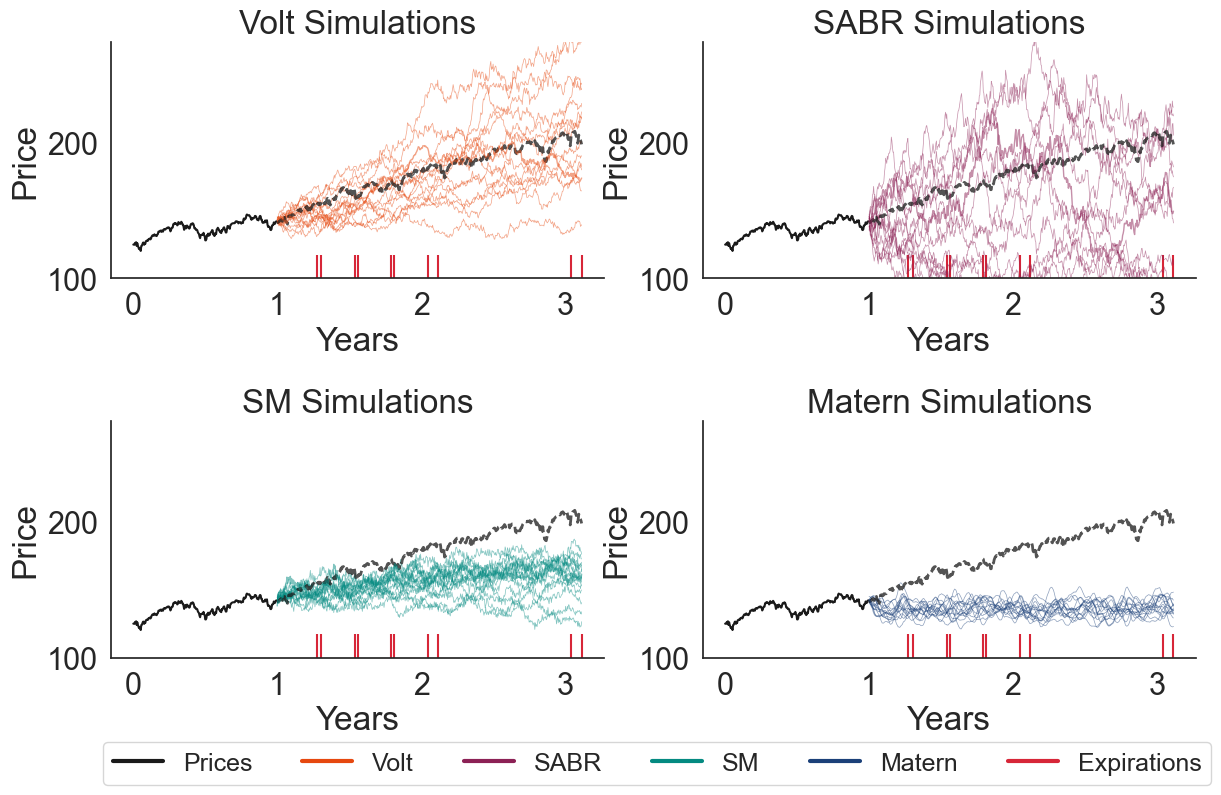

In [108]:
colors = ["#1b4079","#c6ddf0","#50723C","#b9e28c","#8c2155","#af7595","#e6480f","#fa9500", "#808080"]
colors = ["#1b4079", "#C6DDF0", "#048A81", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
fs = 16

sns.set(font_scale=2.)
sns.set_style("white")

fig, ax = plt.subplots(2,2, figsize=(14, 8), dpi=100)
plt.subplots_adjust(hspace=0.6)
vol_scale = 1.

## VOLTRON PLOT ##
SimPlotter(px_paths, 6, "Volt", ax[0,0])
SimPlotter(sabr_paths.T, 4, "SABR", ax[0,1])
SimPlotter(sm_paths, 2, "SM", ax[1,0])
SimPlotter(mat_paths, 0, "Matern", ax[1,1])
lw = 3.

custom_lines = [Line2D([0], [0], color='k', lw=lw),
                Line2D([0], [0], color=colors[6], lw=lw),
                Line2D([0], [0], color=colors[4], lw=lw),
                Line2D([0], [0], color=colors[2], lw=lw),
                Line2D([0], [0], color=colors[0], lw=lw),
                Line2D([0], [0], color="#D72638", lw=lw),]

# fig.legend(custom_lines, ["Train", "Test", "Voltron", "SM", "Matern", "Expirations"],
#           ncol=1, frameon=False, bbox_to_anchor=(1.1, 0.65), fontsize=fs+1)

fig.legend(custom_lines, ["Prices", "Volt", "SABR", "SM", "Matern", "Expirations"],
          ncol=6, bbox_to_anchor=(0.92, 0.02), fontsize=fs+2)


sns.despine()
plt.savefig("./full_diffusions.pdf", bbox_inches="tight")
plt.show()


In [81]:
logger = []
days = np.datetime_as_string(edays, 'D')
for day in range(px_samples.shape[1]):
    for smpl in range(px_samples.shape[0]):
        logger.append([px_samples[smpl, day].item(), days[day], "Volt"])
        
    for smpl in range(mat_samples.shape[0]):
        logger.append([mat_samples[smpl, day].item(), days[day][5:], "Matern"])
        
    for smpl in range(sm_samples.shape[0]):
        logger.append([sm_samples[smpl, day].item(), days[day][5:], "SM"])
        
    for smpl in range(sabr_samples.shape[0]):
        logger.append([sabr_samples.t()[smpl, day].item(), days[day], "SABR"])
df = pd.DataFrame(logger)
df.columns = ['Price', 'Date', "Type"]

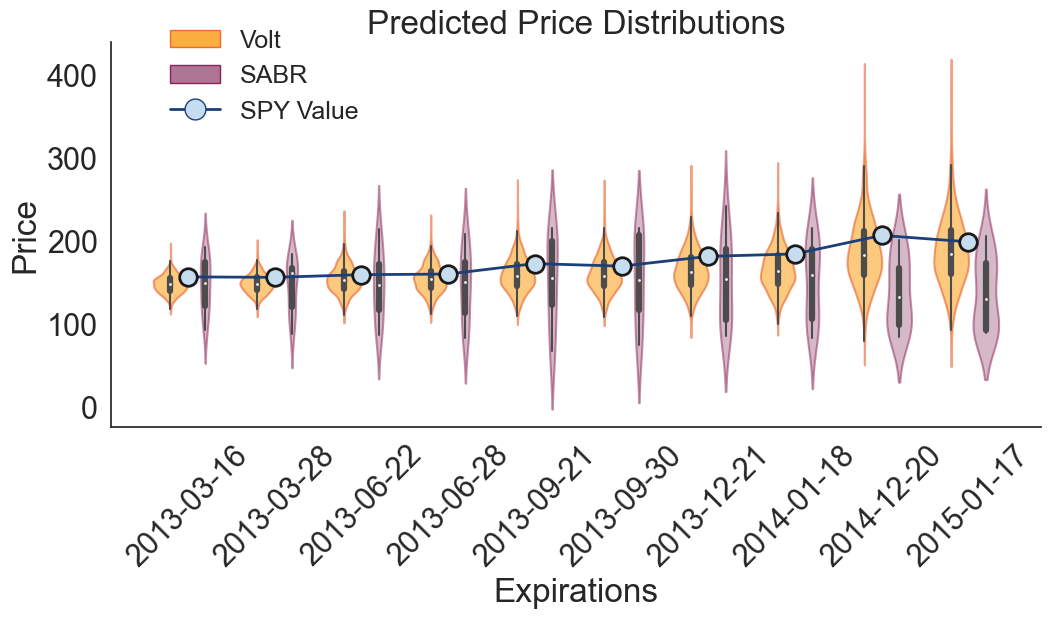

In [100]:
fs = 16
fig, ax = plt.subplots(figsize=(12,5))
# violins = sns.violinplot(x='Date', y='Price', data=df[df.Type=="Voltron"])
violins = sns.violinplot(x='Date', y='Price', data=df[df.Type.isin(["Volt", "SABR"])],
                        split=False, hue="Type", c=[colors[6], colors[2]])
# violins = sns.violinplot(x='Date', y='Price', data=df[df.Type == "Matern"], hue="Type")
# violins = sns.violinplot(x='Date', y='Price', data=df, hue="Type")
for violin in violins.collections[::4]:
    violin.set_alpha(0.5)
    violin.set_edgecolor(colors[6])
    violin.set_facecolor(colors[7])
    
for violin in violins.collections[2::4]:
    violin.set_alpha(0.5)
    violin.set_edgecolor(colors[4])
    violin.set_facecolor(colors[5])
    
    
plt.scatter(np.arange(px_samples.shape[1]), test_y[ntests-1], color=colors[1], zorder=4, 
            s=160,
            edgecolor='k',lw=2.,
           label="Observed Price")
plt.plot(np.arange(px_samples.shape[1]), test_y[ntests-1], 
         color=colors[0], zorder=3, lw=2.)
plt.xlabel("Expirations")
plt.xticks(rotation=45)
sns.despine()
ax.get_legend().set_visible(False)

legend_elements = [Patch(facecolor=colors[7], edgecolor=colors[6], alpha=0.75,
                         label='Volt'),
                   Patch(facecolor=colors[5], edgecolor=colors[4],
                         label='SABR'),
                   Line2D([0], [0], marker='o', color=colors[0], label='SPY Value',
                          markerfacecolor=colors[1], markersize=15, lw=2.)]

fig.legend(handles = legend_elements, fontsize=fs+2,
          bbox_to_anchor=(0.35, 0.95), frameon=False)

plt.title("Predicted Price Distributions")
# plt.ylim(0, 500)
plt.savefig("./voltron-sabr-distribution-plot.pdf", bbox_inches='tight')

plt.show()

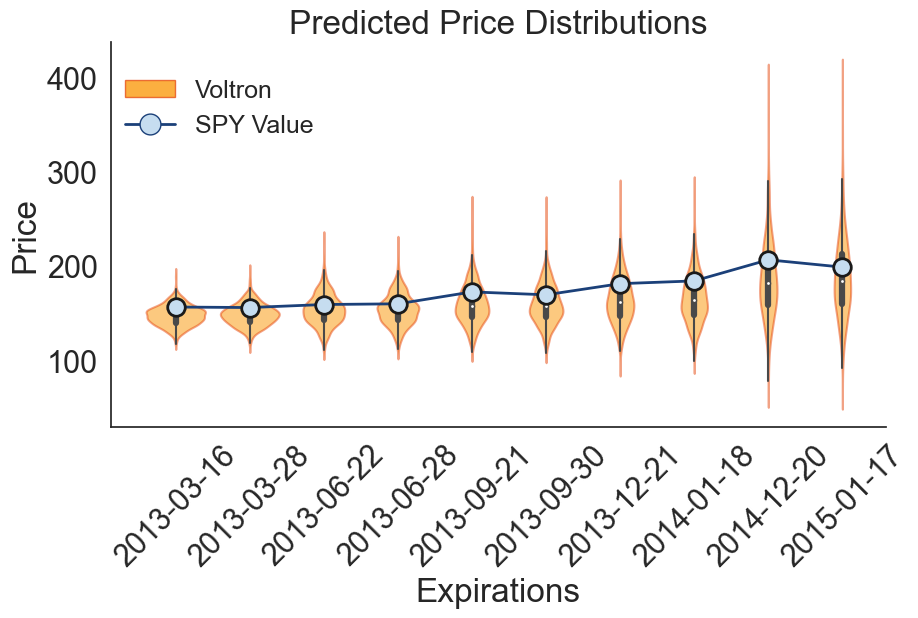

In [85]:
fs = 16
fig, ax = plt.subplots(figsize=(10,5))
# violins = sns.violinplot(x='Date', y='Price', data=df[df.Type=="Voltron"])
# violins = sns.violinplot(x='Date', y='Price', data=df[df.Type.isin(["Voltron", "SM"])],
                        # split=True, hue="Type", c=[colors[6], colors[2]])
# violins = sns.violinplot(x='Date', y='Price', data=df[df.Type == "Matern"], hue="Type")
violins = sns.violinplot(x='Date', y='Price', data=df[df.Type == "Volt"])
for violin in violins.collections[::2]:
    violin.set_alpha(0.5)
    violin.set_edgecolor(colors[6])
    violin.set_facecolor(colors[7])



    
    
plt.scatter(np.arange(px_samples.shape[1]), test_y[ntests-1], color=colors[1], zorder=4, 
            s=160,
            edgecolor='k',lw=2.,
           label="Observed Price")
plt.plot(np.arange(px_samples.shape[1]), test_y[ntests-1], 
         color=colors[0], zorder=3, lw=2.)
plt.xlabel("Expirations")
plt.xticks(rotation=45)
sns.despine()

# plt.legend(loc="upper left",frameon=False, fontsize=fs)

legend_elements = [Patch(facecolor=colors[7], edgecolor=colors[6], alpha=0.75,
                         label='Voltron'),
                   Line2D([0], [0], marker='o', color=colors[0], label='SPY Value',
                          markerfacecolor=colors[1], markersize=15, lw=2.)]

fig.legend(handles = legend_elements, fontsize=fs+2, bbox_to_anchor=(0.35, 0.85), frameon=False)

plt.title("Predicted Price Distributions")
# plt.ylim(0, 500)
plt.savefig("./volton-distribution-plot.pdf", bbox_inches='tight')

plt.show()

In [56]:
true_pxs = test_y[ntests-1]
logger = []
for eday_idx, eday in enumerate(edays):
    eday = pd.Timestamp(eday)
    opts = options[options.expiration==pd.Timestamp(eday)]
    for idx, row in opts.iterrows():
        K = row.strike
        bid = row.bid
        ask = row.ask
        valuation = np.mean(np.maximum(px_samples[:, eday_idx].numpy() - K, 0))
        rtn = np.maximum(true_pxs[eday_idx] - K, 0)
        logger.append([eday, K, bid, ask, valuation, rtn.item(), "Voltron"])

        valuation = np.mean(np.maximum(mat_samples[:, eday_idx].numpy() - K, 0))
        rtn = np.maximum(true_pxs[eday_idx] - K, 0)
        logger.append([eday, K, bid, ask, valuation, rtn.item(), "Matern"])

        valuation = np.mean(np.maximum(sm_samples[:, eday_idx].numpy() - K, 0))
        rtn = np.maximum(true_pxs[eday_idx] - K, 0)
        logger.append([eday, K, bid, ask, valuation, rtn.item(), "SM"])

        valuation = np.mean(np.maximum(sabr_samples.t()[:, eday_idx].numpy() - K, 0))
        rtn = np.maximum(true_pxs[eday_idx] - K, 0)
        logger.append([eday, K, bid, ask, valuation, rtn.item(), "SABR"])

full_dat = pd.DataFrame(logger)
full_dat.columns = ['Expiry', "Strike", "Bid", "Ask", "Valuation", "Return", "Type"]

In [118]:
def PlotPayoff(exp_idx, title, ax, ylabel=False):
    dat = full_dat[full_dat.Expiry == full_dat.Expiry.unique()[exp_idx]]
    g = sns.lineplot(x="Strike", y='Valuation', data=dat, hue="Type", 
                 palette=[colors[6], colors[0], colors[2], colors[4]], lw=2.,
                ax=ax)
    ax.fill_between(dat.Strike, dat.Bid, dat.Ask, color='gray',
                    label="Market Bid/Ask", lw=3.)
    ax.plot(dat.Strike, dat.Return, c='k', label="Payoff", ls="--")
    
    if ylabel:
        ax.set_ylabel("Price (Payoff)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Strike")
    sns.despine()
    ax.set_title(title)
    ax.get_legend().set_visible(False)

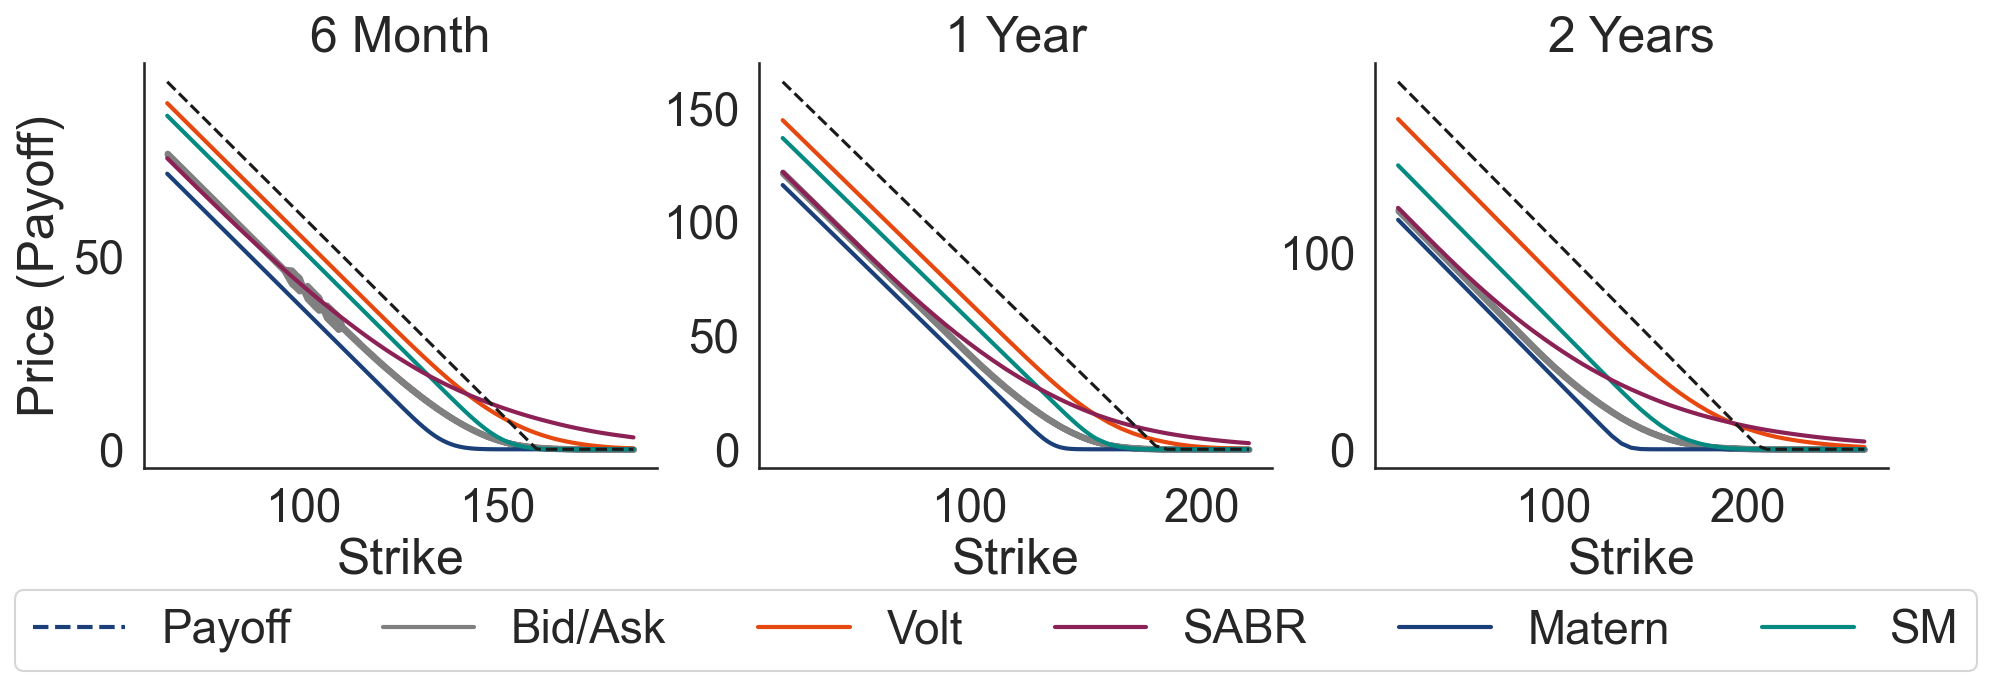

In [123]:
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(15, 3.5))

PlotPayoff(3, "6 Month", ax[0], ylabel=True)
PlotPayoff(6, "1 Year", ax[1])
PlotPayoff(8, "2 Years", ax[2])


lw = 2
custom_lines = [Line2D([0], [0], color=colors[0], lw=lw, ls="--"),
                Line2D([0], [0], color='gray', lw=lw),
                Line2D([0], [0], color=colors[6], lw=lw),
                Line2D([0], [0], color=colors[4], lw=lw),
                Line2D([0], [0], color=colors[0], lw=lw),
                Line2D([0], [0], color=colors[2], lw=lw)]
fig.legend(custom_lines, ["Payoff", "Bid/Ask", "Volt", "SABR", "Matern", "SM"],
          frameon=True, ncol=6, bbox_to_anchor=(0.95, -0.08))
plt.savefig("./payoffs.pdf", bbox_inches="tight")
plt.show()

In [67]:
qday

numpy.datetime64('2012-12-03T00:00:00.000000000')

In [71]:
print(edays[3])
print(edays[6])
print(edays[8])

2013-06-28T00:00:00.000000000
2013-12-21T00:00:00.000000000
2014-12-20T00:00:00.000000000


# Calibration

In [20]:
temp = px_samples[:, 0]
yy = test_y[0]
smp = temp.log().sort(0)[0]
log_px = yy.log()

In [21]:
print(torch.sum(smp < log_px)/smp.shape[0])

tensor(0.3070)


In [22]:
torch.sum(smp < log_px)/smp.shape[0]

tensor(0.3070)

In [128]:
gpytorch.means.ConstantMean()

ConstantMean()